In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('M', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('D', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['Year'] = raw.datetime.dt.year

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [3]:
browsing_df = pd.read_excel('./KB 국민카드_분석.xlsx', sheet_name='Browsing')
experience_df = pd.read_excel('./KB 국민카드_분석.xlsx', sheet_name='Experience')
intial_df = pd.read_excel('./KB 국민카드_분석.xlsx', sheet_name='Initial Exploration')
null_df = pd.read_excel('./KB 국민카드_분석.xlsx', sheet_name='-')

In [7]:
browsing_df.corr()

,중고차매매사이트,캠핑카가격,bmw인증중고차,중고차사이트,중고차시세,모닝중고차가격,신형카니발가격,레이중고차시세,제네시스GV80가격,현대자동차견적내기,인피니티할인,중고차가격,캠핑카중고,카니발가격,테슬라전기차가격,중고캠핑카가격,테슬라모델3보조금,모하비가격,아반떼중고,볼보xc90중고,...,렌탈리스,장기렌탈가격,렌터카리스,리스의장점,장기렌트초기비용,수입차장기렌트비용,리스비교견적,자동차장기렌트장단점,중고자동차리스가격,신차장기렌트카가격,장기렌트VS리스,장기렌트장기리스,차량할부연체,렌트VS리스,전기차장기렌트비용,벤츠장기렌트비용,bmwx5리스가격,자동차렌트와리스차이,자동차할부미납형사고발,자동차리스와렌트
중고차매매사이트,1.00,-0.43,-0.71,-0.62,-0.46,-0.18,-0.51,-0.05,0.12,0.49,-0.21,0.25,-0.04,-0.50,-0.58,-0.53,-0.53,0.50,-0.35,-0.72,...,0.54,0.11,0.14,-0.15,-0.53,-0.53,-0.05,0.65,0.87,0.19,0.18,-0.53,0.01,-0.53,-0.27,0.33,0.46,-0.53,-0.44,-0.53
캠핑카가격,-0.43,1.00,0.07,0.22,-0.04,-0.50,0.11,0.24,-0.53,-0.04,0.02,0.24,0.70,0.24,-0.04,0.52,0.52,-0.30,0.21,0.17,...,-0.56,0.26,-0.18,-0.10,0.52,0.52,-0.39,-0.31,-0.32,-0.04,0.32,0.52,0.18,0.52,0.25,-0.57,-0.09,0.52,0.20,0.52
bmw인증중고차,-0.71,0.07,1.00,0.88,0.61,0.40,0.71,0.31,-0.23,-0.35,0.42,-0.60,0.08,0.70,0.86,0.24,0.24,0.00,0.42,0.82,...,-0.25,-0.42,-0.40,-0.04,0.24,0.24,0.21,-0.54,-0.50,-0.56,-0.30,0.24,0.08,0.24,0.46,-0.27,-0.34,0.24,0.51,0.24
중고차사이트,-0.62,0.22,0.88,1.00,0.60,0.28,0.50,0.43,-0.29,-0.34,0.16,-0.46,0.23,0.55,0.64,0.08,0.08,-0.11,0.61,0.68,...,-0.29,-0.18,-0.29,-0.14,0.08,0.08,0.03,-0.61,-0.46,-0.40,-0.22,0.08,0.25,0.08,0.49,-0.40,-0.23,0.08,0.25,0.08
중고차시세,-0.46,-0.04,0.61,0.60,1.00,0.52,0.42,0.19,0.21,-0.21,0.14,-0.25,0.06,0.45,0.54,-0.14,-0.14,0.06,0.64,0.63,...,-0.06,-0.44,0.19,0.11,-0.14,-0.14,-0.24,-0.18,-0.31,-0.09,0.07,-0.14,0.29,-0.14,0.69,-0.25,-0.14,-0.14,0.27,-0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
벤츠장기렌트비용,0.33,-0.57,-0.27,-0.40,-0.25,0.55,-0.12,-0.20,0.48,-0.10,-0.04,0.04,-0.73,-0.52,-0.10,-0.24,-0.24,0.04,-0.44,-0.34,...,0.74,0.22,0.19,-0.18,-0.24,-0.24,0.62,0.17,0.02,0.25,-0.24,-0.24,0.32,-0.24,-0.19,1.00,0.12,-0.24,-0.17,-0.24
bmwx5리스가격,0.46,-0.09,-0.34,-0.23,-0.14,-0.21,-0.13,-0.15,-0.18,0.10,-0.28,0.00,0.27,-0.12,-0.39,-0.34,-0.34,0.38,0.04,-0.25,...,-0.03,0.07,0.35,-0.32,-0.34,-0.34,-0.06,0.11,0.36,0.07,0.25,-0.34,0.17,-0.34,0.18,0.12,1.00,-0.34,-0.24,-0.34
자동차렌트와리스차이,-0.53,0.52,0.24,0.08,-0.14,-0.19,0.53,-0.16,-0.33,-0.08,0.60,-0.13,0.30,0.52,0.35,1.00,1.00,-0.23,-0.17,0.45,...,-0.48,0.07,-0.32,0.08,1.00,1.00,0.26,-0.24,-0.52,-0.29,-0.20,1.00,-0.13,1.00,-0.07,-0.24,-0.34,1.00,0.70,1.00
자동차할부미납형사고발,-0.44,0.20,0.51,0.25,0.27,0.23,0.92,0.06,-0.17,-0.06,0.95,-0.51,0.35,0.84,0.80,0.70,0.70,0.16,0.07,0.79,...,-0.22,-0.38,-0.31,0.05,0.70,0.70,0.18,-0.17,-0.41,-0.53,-0.14,0.70,-0.09,0.70,0.47,-0.17,-0.24,0.70,1.00,0.70


In [11]:
browsing_df

,datetime,중고차매매사이트,캠핑카가격,bmw인증중고차,중고차사이트,중고차시세,모닝중고차가격,신형카니발가격,레이중고차시세,제네시스GV80가격,현대자동차견적내기,인피니티할인,중고차가격,캠핑카중고,카니발가격,테슬라전기차가격,중고캠핑카가격,테슬라모델3보조금,모하비가격,아반떼중고,...,렌탈리스,장기렌탈가격,렌터카리스,리스의장점,장기렌트초기비용,수입차장기렌트비용,리스비교견적,자동차장기렌트장단점,중고자동차리스가격,신차장기렌트카가격,장기렌트VS리스,장기렌트장기리스,차량할부연체,렌트VS리스,전기차장기렌트비용,벤츠장기렌트비용,bmwx5리스가격,자동차렌트와리스차이,자동차할부미납형사고발,자동차리스와렌트
0,2019-07-01,140,14800,1300,4400,1600,70,20,170,210,20,40,2400,480,1000,110,1,1,1300,1300,...,30,40,50,20,1,1,10,30,20,70,10,1,10,1,10,30,10,1,1,1
1,2019-08-01,210,14800,1300,4400,1900,110,40,210,390,30,20,1900,590,1000,170,0,0,2400,1600,...,40,20,50,20,0,0,0,40,50,50,20,0,10,0,40,30,20,0,0,0
2,2019-09-01,320,9900,1300,4400,1900,170,70,210,390,30,70,1900,590,1300,140,0,0,4400,1600,...,40,20,70,10,0,0,10,90,110,50,10,0,10,0,30,30,30,0,0,0
3,2019-10-01,260,9900,1300,4400,2400,170,40,140,480,40,90,1600,480,1000,170,0,0,2400,1600,...,50,10,50,30,0,0,0,50,70,40,20,0,10,0,30,30,20,0,0,0
4,2019-11-01,320,8100,1000,4400,1600,320,70,210,590,30,210,1600,390,880,260,0,0,2400,1300,...,70,30,40,20,0,0,10,50,70,50,10,0,10,0,20,40,10,0,0,0
5,2019-12-01,260,8100,1600,3600,1900,320,40,210,480,20,90,2400,320,880,260,0,0,2900,1300,...,70,20,50,20,0,0,10,70,90,70,10,0,10,0,20,40,10,0,0,0
6,2020-01-01,170,8100,1900,4400,2400,480,50,170,1300,20,30,1900,260,1000,260,0,0,2400,1600,...,50,20,90,20,0,0,10,70,20,90,10,0,10,0,30,40,10,0,0,0
7,2020-02-01,210,8100,1900,4400,1900,320,210,170,390,10,40,1600,390,1000,260,0,0,1900,1900,...,50,30,70,20,0,0,10,10,30,70,10,0,10,0,30,40,30,0,0,0
8,2020-03-01,210,12100,2900,5400,2400,480,210,260,390,10,50,2400,480,1000,320,0,0,2400,2400,...,70,40,70,10,0,0,10,30,40,90,10,0,30,0,50,40,20,0,0,0
9,2020-04-01,170,12100,2900,5400,2400,260,140,260,320,10,30,2400,590,1300,320,0,0,1900,2900,...,40,30,70,20,0,0,0,30,50,90,10,0,10,0,40,20,10,0,0,0


In [45]:
raw_nfe = non_feature_engineering(raw_all)

In [46]:
raw_nfe

,datetime,count,DateTime
DateTime,,,
2019-07-31,2019-07-01,140,2019-07-01
2019-08-31,2019-08-01,210,2019-08-01
2019-09-30,2019-09-01,320,2019-09-01
2019-10-31,2019-10-01,260,2019-10-01
2019-11-30,2019-11-01,320,2019-11-01
2019-12-31,2019-12-01,260,2019-12-01
2020-01-31,2020-01-01,170,2020-01-01
2020-02-29,2020-02-01,210,2020-02-01
2020-03-31,2020-03-01,210,2020-03-01


In [27]:
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif

In [29]:
feature_engineering_XbyVIF(X_train_fe, 10)

array(['count_seasonal', 'count_diff', 'Year', 'count_trend',
       'count_lag2', 'count_lag1'], dtype=object)

In [32]:
raw_all

,datetime,count,DateTime
DateTime,,,
2019-07-01,2019-07-01,140,2019-07-01
2019-08-01,2019-08-01,210,2019-08-01
2019-09-01,2019-09-01,320,2019-09-01
2019-10-01,2019-10-01,260,2019-10-01
2019-11-01,2019-11-01,320,2019-11-01
2019-12-01,2019-12-01,260,2019-12-01
2020-01-01,2020-01-01,170,2020-01-01
2020-02-01,2020-02-01,210,2020-02-01
2020-03-01,2020-03-01,210,2020-03-01


In [48]:
raw_fe

,datetime,count,DateTime,count_trend,count_seasonal,count_diff,Year,count_lag1,count_lag2
DateTime,,,,,,,,,
2019-07-01 00:00:00,2019-07-01,140,2019-07-01,140.00,-0.04,0.00,2019,140.00,140.00
2019-07-01 01:00:00,2019-07-01,140,2019-07-01,140.00,-0.04,0.00,2019,140.00,140.00
2019-07-01 02:00:00,2019-07-01,140,2019-07-01,140.00,-0.04,0.00,2019,140.00,140.00
2019-07-01 03:00:00,2019-07-01,140,2019-07-01,140.00,-0.03,0.00,2019,140.00,140.00
2019-07-01 04:00:00,2019-07-01,140,2019-07-01,140.00,-0.03,0.00,2019,140.00,140.00
...,...,...,...,...,...,...,...,...,...
2020-05-31 20:00:00,2020-05-01,110,2020-05-01,110.00,0.03,0.00,2020,110.00,110.00
2020-05-31 21:00:00,2020-05-01,110,2020-05-01,110.00,0.04,0.00,2020,110.00,110.00
2020-05-31 22:00:00,2020-05-01,110,2020-05-01,110.00,0.04,0.00,2020,110.00,110.00


In [52]:
browsing_df

,datetime,중고차매매사이트,캠핑카가격,bmw인증중고차,중고차사이트,중고차시세,모닝중고차가격,신형카니발가격,레이중고차시세,제네시스GV80가격,현대자동차견적내기,인피니티할인,중고차가격,캠핑카중고,카니발가격,테슬라전기차가격,중고캠핑카가격,테슬라모델3보조금,모하비가격,아반떼중고,...,렌탈리스,장기렌탈가격,렌터카리스,리스의장점,장기렌트초기비용,수입차장기렌트비용,리스비교견적,자동차장기렌트장단점,중고자동차리스가격,신차장기렌트카가격,장기렌트VS리스,장기렌트장기리스,차량할부연체,렌트VS리스,전기차장기렌트비용,벤츠장기렌트비용,bmwx5리스가격,자동차렌트와리스차이,자동차할부미납형사고발,자동차리스와렌트
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-01,2019-07-01,140,14800,1300,4400,1600,70,20,170,210,20,40,2400,480,1000,110,1,1,1300,1300,...,30,40,50,20,1,1,10,30,20,70,10,1,10,1,10,30,10,1,1,1
2019-08-01,2019-08-01,210,14800,1300,4400,1900,110,40,210,390,30,20,1900,590,1000,170,0,0,2400,1600,...,40,20,50,20,0,0,0,40,50,50,20,0,10,0,40,30,20,0,0,0
2019-09-01,2019-09-01,320,9900,1300,4400,1900,170,70,210,390,30,70,1900,590,1300,140,0,0,4400,1600,...,40,20,70,10,0,0,10,90,110,50,10,0,10,0,30,30,30,0,0,0
2019-10-01,2019-10-01,260,9900,1300,4400,2400,170,40,140,480,40,90,1600,480,1000,170,0,0,2400,1600,...,50,10,50,30,0,0,0,50,70,40,20,0,10,0,30,30,20,0,0,0
2019-11-01,2019-11-01,320,8100,1000,4400,1600,320,70,210,590,30,210,1600,390,880,260,0,0,2400,1300,...,70,30,40,20,0,0,10,50,70,50,10,0,10,0,20,40,10,0,0,0
2019-12-01,2019-12-01,260,8100,1600,3600,1900,320,40,210,480,20,90,2400,320,880,260,0,0,2900,1300,...,70,20,50,20,0,0,10,70,90,70,10,0,10,0,20,40,10,0,0,0
2020-01-01,2020-01-01,170,8100,1900,4400,2400,480,50,170,1300,20,30,1900,260,1000,260,0,0,2400,1600,...,50,20,90,20,0,0,10,70,20,90,10,0,10,0,30,40,10,0,0,0
2020-02-01,2020-02-01,210,8100,1900,4400,1900,320,210,170,390,10,40,1600,390,1000,260,0,0,1900,1900,...,50,30,70,20,0,0,10,10,30,70,10,0,10,0,30,40,30,0,0,0
2020-03-01,2020-03-01,210,12100,2900,5400,2400,480,210,260,390,10,50,2400,480,1000,320,0,0,2400,2400,...,70,40,70,10,0,0,10,30,40,90,10,0,30,0,50,40,20,0,0,0


In [57]:
browsing_df

,datetime,중고차매매사이트,캠핑카가격,bmw인증중고차,중고차사이트,중고차시세,모닝중고차가격,신형카니발가격,레이중고차시세,제네시스GV80가격,현대자동차견적내기,인피니티할인,중고차가격,캠핑카중고,카니발가격,테슬라전기차가격,중고캠핑카가격,테슬라모델3보조금,모하비가격,아반떼중고,...,렌탈리스,장기렌탈가격,렌터카리스,리스의장점,장기렌트초기비용,수입차장기렌트비용,리스비교견적,자동차장기렌트장단점,중고자동차리스가격,신차장기렌트카가격,장기렌트VS리스,장기렌트장기리스,차량할부연체,렌트VS리스,전기차장기렌트비용,벤츠장기렌트비용,bmwx5리스가격,자동차렌트와리스차이,자동차할부미납형사고발,자동차리스와렌트
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-01,2019-07-01,140,14800,1300,4400,1600,70,20,170,210,20,40,2400,480,1000,110,1,1,1300,1300,...,30,40,50,20,1,1,10,30,20,70,10,1,10,1,10,30,10,1,1,1
2019-08-01,2019-08-01,210,14800,1300,4400,1900,110,40,210,390,30,20,1900,590,1000,170,0,0,2400,1600,...,40,20,50,20,0,0,0,40,50,50,20,0,10,0,40,30,20,0,0,0
2019-09-01,2019-09-01,320,9900,1300,4400,1900,170,70,210,390,30,70,1900,590,1300,140,0,0,4400,1600,...,40,20,70,10,0,0,10,90,110,50,10,0,10,0,30,30,30,0,0,0
2019-10-01,2019-10-01,260,9900,1300,4400,2400,170,40,140,480,40,90,1600,480,1000,170,0,0,2400,1600,...,50,10,50,30,0,0,0,50,70,40,20,0,10,0,30,30,20,0,0,0
2019-11-01,2019-11-01,320,8100,1000,4400,1600,320,70,210,590,30,210,1600,390,880,260,0,0,2400,1300,...,70,30,40,20,0,0,10,50,70,50,10,0,10,0,20,40,10,0,0,0
2019-12-01,2019-12-01,260,8100,1600,3600,1900,320,40,210,480,20,90,2400,320,880,260,0,0,2900,1300,...,70,20,50,20,0,0,10,70,90,70,10,0,10,0,20,40,10,0,0,0
2020-01-01,2020-01-01,170,8100,1900,4400,2400,480,50,170,1300,20,30,1900,260,1000,260,0,0,2400,1600,...,50,20,90,20,0,0,10,70,20,90,10,0,10,0,30,40,10,0,0,0
2020-02-01,2020-02-01,210,8100,1900,4400,1900,320,210,170,390,10,40,1600,390,1000,260,0,0,1900,1900,...,50,30,70,20,0,0,10,10,30,70,10,0,10,0,30,40,30,0,0,0
2020-03-01,2020-03-01,210,12100,2900,5400,2400,480,210,260,390,10,50,2400,480,1000,320,0,0,2400,2400,...,70,40,70,10,0,0,10,30,40,90,10,0,30,0,50,40,20,0,0,0


In [12]:
raw_all = browsing_df.rename(columns={'캠핑카가격':'count'}, inplace=False)
raw_all = raw_all[['datetime','count']]

In [13]:
raw_all

,datetime,count
0,2019-07-01,14800
1,2019-08-01,14800
2,2019-09-01,9900
3,2019-10-01,9900
4,2019-11-01,8100
5,2019-12-01,8100
6,2020-01-01,8100
7,2020-02-01,8100
8,2020-03-01,12100
9,2020-04-01,12100


Train_size: (275, 8) Test_size: (62, 8)
X_train: (275, 6) Y_train: (275, 1)
X_test: (62, 6) Y_test: (62, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.067e+32
Date:                Sun, 27 Dec 2020   Prob (F-statistic):                        0.00
Time:                        16:46:38   Log-Likelihood:                          6673.3
No. Observations:                 275   AIC:                                 -1.333e+04
Df Residuals:                     269   BIC:                                 -1.331e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
count_trend    -8.882e-16   1.98e-15     -0.450      0.653   -4.78e-15       3e-15
count_seasonal -4.441e-15   1.75e-14     -0.254      0.799   -3.88e-14    2.99e-14
count_diff         1.0000   1.55e-15   6.45e+14      0.000       1.000       1.000
Year            1.392e-15   8.71e-16      1.598      0.111   -3.23e-16    3.11e-15
count_lag1         1.0000   1.76e-15   5.67e+14      0.000       1.000       1.000
count_lag2       2.22e-16   1.21e-15      0.183      0.855   -2.17e-15    2.61e-15
==============================================================================
Omnibus:                      183.312   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.941
Skew:                           0.586   Prob(JB):                     7.03e-08
Kurtosis:                       1.775   Cond. No.                         770.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,MSE,MAPE
Train,0.00,0.00,0.00
Test,0.00,0.00,0.00


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-1.62,0.69,0.79,247.20,"1,044.49","1,980.74","4,447.89",0.01
p-value,0.47,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,14.00,16.00,nan,nan,nan,nan,nan,NaN
Used Observations,260.00,nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.46,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-13,893.61",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


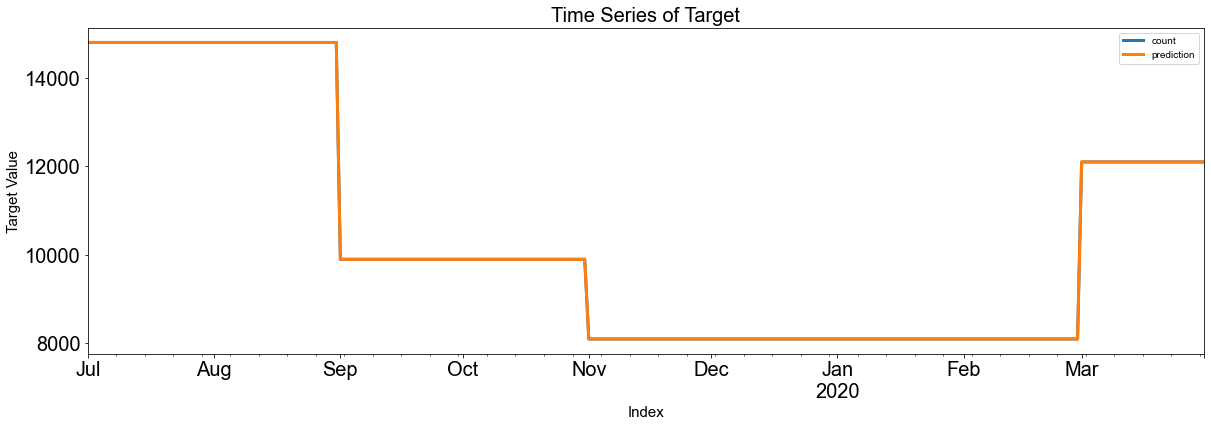

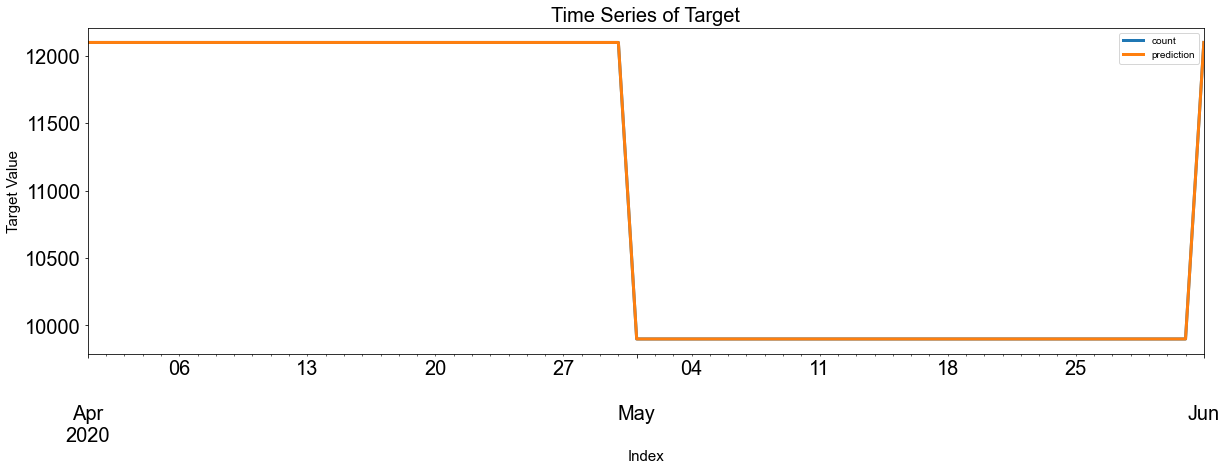

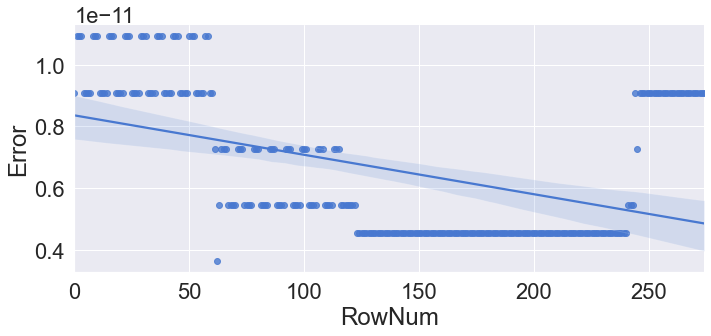

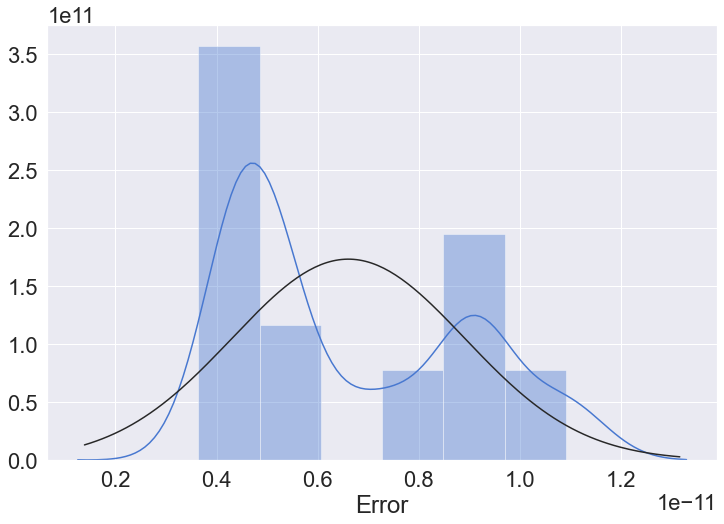

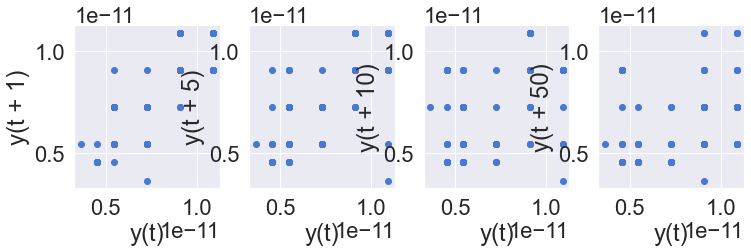

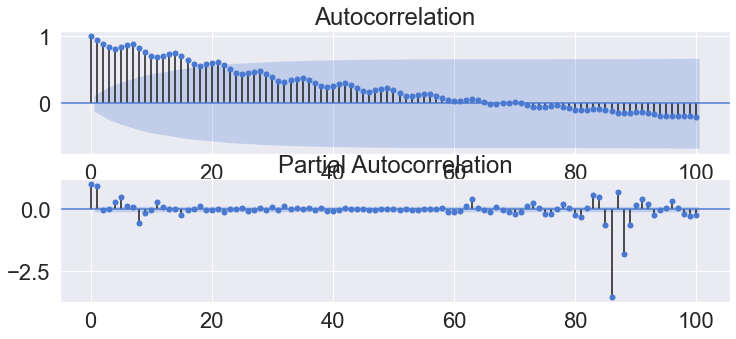

In [14]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'

# Feature Engineering
raw_fe = feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(raw_fe, Y_colname, X_colname, '2020-04-01')

# Applying Base Model
fit_reg1_fe = sm.OLS(Y_train_fe, X_train_fe).fit()
display(fit_reg1_fe.summary())
pred_tr_reg1_fe = fit_reg1_fe.predict(X_train_fe).values
pred_te_reg1_fe = fit_reg1_fe.predict(X_test_fe).values

# Evaluation
Score_reg1_fe, Resid_tr_reg1_fe, Resid_te_reg1_fe = evaluation_trte(Y_train_fe, pred_tr_reg1_fe,
                                                                Y_test_fe, pred_te_reg1_fe, graph_on=True)
display(Score_reg1_fe)

# Error Analysis
error_analysis(Resid_tr_reg1_fe, ['Error'], X_train_fe, graph_on=True)